# Hyperparameter Tuning {#sec-hyperparameter-tuning}

Hyperparameter tuning is an important, but often difficult and computationally intensive task.
Changing the architecture of a neural network or the learning rate of an optimizer can have a significant impact on the performance.

The goal of hyperparameter tuning is to optimize the hyperparameters in a way that improves the performance of the machine learning or deep learning model.
The simplest, but also most computationally expensive, approach uses manual search (or trial-and-error [@Meignan:2015vp]).
Commonly encountered is simple random search, i.e., random and repeated selection of hyperparameters for evaluation, and lattice search ("grid search").
In addition, methods that perform directed search  and other model-free algorithms, i.e., algorithms that do not explicitly rely on a model, e.g., evolution strategies [@Bart13j] or pattern search [@Torczon00] play an important role.
Also, "hyperband", i.e., a multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive bisections to stop configurations with poor performance [@Li16a], is very common in hyperparameter tuning.
The most sophisticated and efficient approaches are the Bayesian optimization and surrogate model based optimization methods, which are based on the optimization of cost functions determined by simulations or experiments.

We consider below a surrogate model based optimization-based hyperparameter tuning approach based on the Python version of the SPOT ("Sequential Parameter Optimization Toolbox") [@BLP05], which is suitable for situations where only limited resources are available. This may be due to limited availability and cost of hardware, or due to the fact that confidential data may only be processed locally, e.g., due to legal requirements.
Furthermore, in our approach, the understanding of algorithms is seen as a key tool for enabling transparency and explainability. This can be enabled, for example, by quantifying the contribution of machine learning and deep learning components (nodes, layers, split decisions, activation functions, etc.).
Understanding the importance of hyperparameters and the interactions between multiple hyperparameters plays a major role in the interpretability and explainability of machine learning models.
SPOT provides statistical tools for understanding hyperparameters and their interactions. Last but not least, it should be noted that the SPOT software code is available in the open source `spotPython` package on github^[[https://github.com/sequential-parameter-optimization](https://github.com/sequential-parameter-optimization)], allowing replicability of the results.
This tutorial descries the Python variant of SPOT, which is called `spotPython`. The R implementation is described in @bart21i.
SPOT is an established open source software that has been maintained for more than 15 years [@BLP05] [@bart21i].

This tutorial is structured as follows. The concept of the hyperparameter tuning software `spotPython` is described in @sec-spot. 
@sec-quickstart ("Quickstart") describes the execution of the example from the tutorial "Hyperparameter Tuning with Ray Tune" [@pyto23a].
@sec-hyperparameter-tuning-for-pytorch describes the integration of `spotPython` into the ``PyTorch`` training workflow in detail and presents the results. Finally, @sec-summary presents a summary and an outlook.

::: {.callout-note}
The corresponding ` .ipynb` notebook [@bart23e] is updated regularly and reflects updates and changes in the `spotPython` package.
It can be downloaded from [https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb](https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb).
:::


# The Hyperparameter Tuning Software SPOT {#sec-spot}

Surrogate model based optimization methods are common approaches in simulation and optimization. SPOT was developed because there is a great need for sound statistical analysis of simulation and optimization algorithms. SPOT includes methods for tuning based on classical regression and analysis of variance techniques.
It presents tree-based models such as classification and regression trees and random forests as well as Bayesian optimization (Gaussian process models, also known as Kriging). Combinations of different meta-modeling approaches are possible. SPOT comes with a sophisticated surrogate model based optimization method, that can handle discrete and continuous inputs. Furthermore, any model implemented in `scikit-learn` can be used out-of-the-box as a surrogate in `spotPython`.

SPOT implements key techniques such as exploratory fitness landscape analysis and sensitivity analysis. It can be used to understand the performance of various algorithms, while simultaneously giving insights into their algorithmic behavior.
In addition, SPOT can be used as an optimizer and for automatic and interactive tuning. Details on SPOT and its use in practice are given by @bart21i.

A typical hyperparameter tuning process with `spotPython` consists of the following steps:

1. Loading the data (training and test datasets), see @sec-data-loading.
2. Specification of the preprocessing model, see @sec-specification-of-preprocessing-model. This model is called `prep_model` ("preparation" or pre-processing).
The information required for the hyperparameter tuning is stored in the dictionary `fun_control`. Thus, the information needed for the execution of the hyperparameter tuning is available in a readable form.
3. Selection of the machine learning or deep learning model to be tuned, see @sec-selection-of-the-algorithm. This is called the `core_model`. Once the `core_model` is defined, then the associated hyperparameters are stored in the `fun_control` dictionary. First, the hyperparameters of the `core_model` are initialized with the default values of the `core_model`.
As default values we use the default values contained in the `spotPython` package for the algorithms of the `torch` package.
4. Modification of the default values for the hyperparameters used in `core_model`, see @sec-modification-of-default-values. This step is optional.
   1. numeric parameters are modified by changing the bounds.
   2. categorical parameters are modified by changing the categories ("levels").
5. Selection of target function (loss function) for the optimizer, see @sec-selection-of-target-function.
6. Calling SPOT with the corresponding parameters, see @sec-call-the-hyperparameter-tuner. The results are stored in a dictionary and are available for further analysis.
7. Presentation, visualization and interpretation of the results, see @sec-results-tuning.


# Quickstart {#sec-quickstart}

In [1]:
#| echo: true
#| eval: false
import numpy as np
import pandas as pd
import itertools
from math import inf
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.nn as nn

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from spotPython.spot import spot
from spotPython.utils.init import fun_control_init
from spotPython.data.torchdata import load_data_cifar10
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    get_var_type,
    get_var_name,
    get_bound_values,
    get_one_core_model_from_X,
    get_default_hyperparameters_as_array
    )
from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netvbdp import Net_vbdp
# from spotPython.torch.netcifar10 import Net_CIFAR10
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
from spotPython.torch.dataframedataset import DataFrameDataset
from spotPython.torch.mapk import MAPK
from spotPython.data.vbdp import modify_vbdp_dataframe, combine_features

# Feature Engineering

In [2]:

#| echo: true
#| eval: false
fun_control = fun_control_init(task="classification", tensorboard_path="runs/25_spot_torch_vbdp_1440")
fun_control.update({"show_batch_interval": 100_000_000})
# load data
train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# # Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])
train_df.head()

# convert all entries to int for faster processing
train_df = train_df.astype(int)

In [3]:
df_new = train_df.copy()
# save the target column using "target_column" as the column name
target = train_df[target_column]
# remove the target column
df_new = df_new.drop(columns=[target_column])
train_df = combine_features(df_new)
# add the target column back
train_df[target_column] = target
train_df.head()

/var/folders/2s/6yp637zs1rl01_hhlx9ncpwh0000gn/T/ipykernel_88615/3336454340.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[target_column] = target


,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,6039,6040,6041,6042,6043,6044,6045,6046,6047,prognosis
0,1,1,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
2,0,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,0,1,1,0,3
3,0,0,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,1,0,0,0,6


* feature engineering: 6112 features

In [4]:
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)


(707, 6113)
(530, 6113)
(177, 6113)


In [5]:
dtype_x = torch.float32
dtype_y = torch.long
train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)

In [6]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})


In [7]:

# add the nn model to the fun_control dictionary
fun_control = add_core_model_to_fun_control(core_model=Net_vbdp,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict)
# modify the hyperparameter levels
fun_control = modify_hyper_parameter_bounds(fun_control, "_L0", bounds=[n_features, n_features])
# fun_control = modify_hyper_parameter_bounds(fun_control, "l1", bounds=[3, 4])
# fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[2, 9])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 6])
fun_control = modify_hyper_parameter_bounds(fun_control, "lr_mult", bounds=[1e-3, 1e-3])
fun_control = modify_hyper_parameter_bounds(fun_control, "sgd_momentum", bounds=[0.9, 0.9])
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "AdamW", "Adamax", "NAdam"])
# select metric and loss function
# metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=11)
metric_torch = MAPK(k=3)
loss_torch = CrossEntropyLoss()
# loss_torch = NLLLoss()
fun_control.update({
               "metric_torch": metric_torch,
               "loss_function": loss_torch,
               "device": "cpu",
               })
# extract the variable types, names, and bounds
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

# get the default hyperparameters as array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

# get the objective function
fun = HyperTorch().fun_torch

# initialize spot
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1440,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
# run spot
spot_tuner.run(X_start=X_start)



config: {'_L0': 6112, 'l1': 8192, 'dropout_prob': 0.4475780541539, 'lr_mult': 0.001, 'batch_size': 16, 'epochs': 64, 'k_folds': 1, 'patience': 16, 'optimizer': 'Adam', 'sgd_momentum': 0.9}
Epoch: 1
Loss on hold-out set: 2.3977014337267195
Accuracy on hold-out set: 0.14150943396226415
MAPK value on hold-out data: 0.16981132075471697
Epoch: 2
Loss on hold-out set: 2.39763673714229
Accuracy on hold-out set: 0.11320754716981132
MAPK value on hold-out data: 0.16352201257861634
Epoch: 3
Loss on hold-out set: 2.3975972277777537
Accuracy on hold-out set: 0.1320754716981132
MAPK value on hold-out data: 0.16588050314465408
Epoch: 4
Loss on hold-out set: 2.3975648198808943
Accuracy on hold-out set: 0.12264150943396226
MAPK value on hold-out data: 0.17374213836477986
Epoch: 5
Loss on hold-out set: 2.39747953414917
Accuracy on hold-out set: 0.08962264150943396
MAPK value on hold-out data: 0.18238993710691823
Epoch: 6
Loss on hold-out set: 2.3974299260548184
Accuracy on hold-out set: 0.070754716981

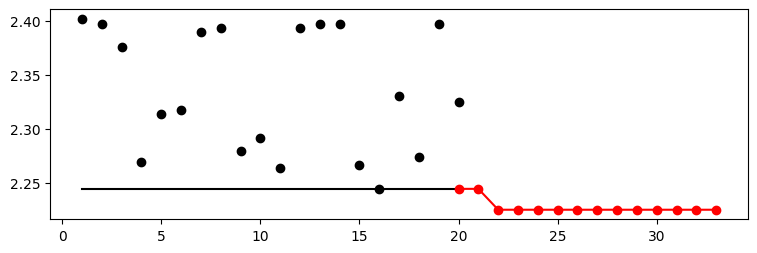

In [8]:
#| echo: true
#| eval: false
spot_tuner.plot_progress()

In [9]:
#| echo: true
#| eval: false
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |              tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|--------------------|-----------------------|--------------|---------|
| _L0          | int    | 64        |  6112.0 |  6112.0 |             6112.0 | None                  |         0.00 |         |
| l1           | int    | 8         |     8.0 |    16.0 |               15.0 | transform_power_2_int |       100.00 | ***     |
| dropout_prob | float  | 0.01      |     0.0 |     0.9 | 0.2702733206852461 | None                  |         0.00 |         |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 |              0.001 | None                  |         0.00 |         |
| batch_size   | int    | 4         |     1.0 |     4.0 |                3.0 | transform_power_2_int |         0.00 |         |
| epochs       | int    | 4         |     4.0 |     9.0 |                6.0 | transform_power_2_int |  

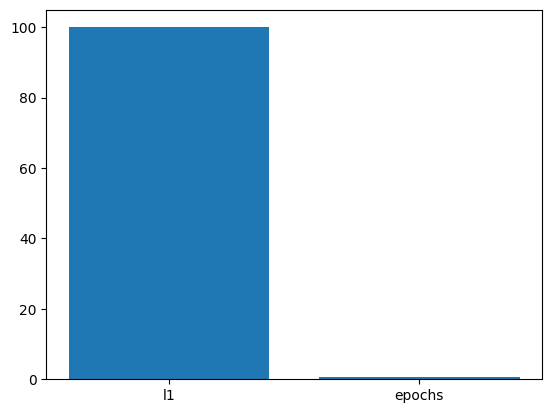

In [10]:
#| echo: true
#| eval: false
spot_tuner.plot_importance()

In [11]:
#| echo: true
#| eval: false
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_vbdp(
  (fc1): Linear(in_features=6112, out_features=32768, bias=True)
  (fc2): Linear(in_features=32768, out_features=16384, bias=True)
  (fc3): Linear(in_features=16384, out_features=8192, bias=True)
  (fc4): Linear(in_features=8192, out_features=4096, bias=True)
  (fc5): Linear(in_features=4096, out_features=11, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.2702733206852461, inplace=False)
  (dropout2): Dropout(p=0.13513666034262306, inplace=False)
)

In [12]:
from spotPython.torch.mapk import MAPK
metric_torch = MAPK(k=3)
fun_control.update({
               "metric_torch": metric_torch,               
               })

train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = "cpu",
        path=None,
        task=fun_control["task"],)

Epoch: 1
Loss on hold-out set: 2.3973650137583413
Accuracy on hold-out set: 0.09905660377358491
MAPK value on hold-out data: 0.17374213836477986
Epoch: 2
Loss on hold-out set: 2.396639823913574
Accuracy on hold-out set: 0.08962264150943396
MAPK value on hold-out data: 0.19182389937106917
Epoch: 3
Loss on hold-out set: 2.3959356590553567
Accuracy on hold-out set: 0.08962264150943396
MAPK value on hold-out data: 0.19103773584905662
Epoch: 4
Loss on hold-out set: 2.394958151711358
Accuracy on hold-out set: 0.08490566037735849
MAPK value on hold-out data: 0.18632075471698112
Epoch: 5
Loss on hold-out set: 2.3933341149930603
Accuracy on hold-out set: 0.08490566037735849
MAPK value on hold-out data: 0.18867924528301888
Epoch: 6
Loss on hold-out set: 2.3899965904377125
Accuracy on hold-out set: 0.1320754716981132
MAPK value on hold-out data: 0.18710691823899367
Epoch: 7
Loss on hold-out set: 2.3840286466810436
Accuracy on hold-out set: 0.18867924528301888
MAPK value on hold-out data: 0.195754

In [13]:
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = "cpu",
            task=fun_control["task"],)

Loss on hold-out set: 2.2551776326220967
Accuracy on hold-out set: 0.2711864406779661
MAPK value on hold-out data: 0.2589453860640301
Final evaluation: Validation loss: 2.2551776326220967
Final evaluation: Validation metric: 0.2589453860640301
----------------------------------------------


(2.2551776326220967, nan, 0.2589453860640301)

## Cross-validated Evaluations

* This is the evaluation that will be used in the comparison (evaluatecv has to be updated before, to get metric vlaues!):

In [14]:
from spotPython.torch.traintest import evaluate_cv
# modify k-kolds:+
setattr(model_spot, "k_folds",  10)
evaluate_cv(net=model_spot, dataset=fun_control["data"], loss_function=fun_control["loss_function"], metric=fun_control["metric_torch"], task=fun_control["task"], writer=fun_control["writer"], writerId="model_spot_cv", device="cpu")

Fold: 1
Epoch: 1
Loss on hold-out set: 2.396343575583564
Accuracy on hold-out set: 0.11267605633802817
MAPK value on hold-out data: 0.1737089201877934
Epoch: 2
Loss on hold-out set: 2.3935661051008434
Accuracy on hold-out set: 0.11267605633802817
MAPK value on hold-out data: 0.16666666666666669
Epoch: 3
Loss on hold-out set: 2.3875109354654946
Accuracy on hold-out set: 0.11267605633802817
MAPK value on hold-out data: 0.18544600938967137
Epoch: 4
Loss on hold-out set: 2.374066617753771
Accuracy on hold-out set: 0.19718309859154928
MAPK value on hold-out data: 0.19248826291079812
Epoch: 5
Loss on hold-out set: 2.347059382332696
Accuracy on hold-out set: 0.28169014084507044
MAPK value on hold-out data: 0.23239436619718304
Epoch: 6
Loss on hold-out set: 2.297019455167982
Accuracy on hold-out set: 0.28169014084507044
MAPK value on hold-out data: 0.28403755868544595
Epoch: 7
Loss on hold-out set: 2.260902855131361
Accuracy on hold-out set: 0.2676056338028169
MAPK value on hold-out data: 0.29

(2.255827502409617, nan, 0.28835010060362176)

l1:  100.0
epochs:  0.6358329698846965


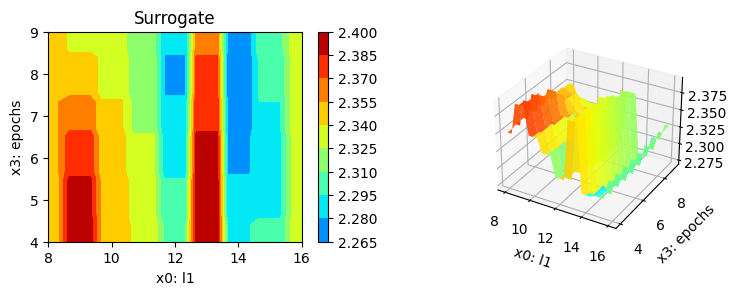

In [15]:
#| echo: true
#| eval: false
spot_tuner.plot_important_hyperparameter_contour()

In [16]:
# close tensorbaoard writer
if fun_control["writer"] is not None:
    fun_control["writer"].close()